In [1]:
# %load_ext autoreload
# %autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [2]:
import os
import utils
import yaml
import numpy as np
# Open config
with open('config.yaml', 'r') as file:
    args = yaml.safe_load(file)

# Get image paths and labels from dataset
dataset_path = os.path.join(args['dataset_dir'], args['dataset_name'])
file_paths, labels = utils.getDataset(dataset_path, args['dataset_name'])

In [3]:
# Split image paths and labels using Stratified
files_train, labels_train, files_test, labels_test = utils.stratifiedSortedSplit(
file_paths, labels, args['train_size'], args['test_size'], args['random_seed'])

print(np.unique(labels_train, return_counts=True)[1].mean())
print(np.unique(labels_test, return_counts=True)[1].mean())

2.0
1.0


In [4]:
from datasets import CasiaDataset
train_dataset = CasiaDataset(
    files_train, labels_train, final_shape=args['final_shape'], **args['train_dataset'])
test_dataset = CasiaDataset(
    files_test, labels_test, final_shape=args['final_shape'], **args['test_dataset'])

In [5]:
# from torchvision.datasets import MNIST
# from torchvision import transforms

# mean, std = 0.1307, 0.3081

# train_dataset = MNIST('../data/MNIST', train=True, download=True,
#                              transform=transforms.Compose([
#                                  transforms.ToTensor(),
#                                  transforms.Normalize((mean,), (std,))
#                              ]))
# test_dataset = MNIST('../data/MNIST', train=False, download=True,
#                             transform=transforms.Compose([
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((mean,), (std,))
#                             ]))
# n_classes = 10

## Common setup

In [70]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(5,5))
    
    classes = np.unique(targets.astype(int))[:10]
    
    legends = [str(i+1) for i in classes]


    for i in classes:
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5)
            
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(legends)

def extract_embeddings(dataloader, model, device):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.to(device)
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [7]:
from torch.utils.data import DataLoader

# # Set up data loaders
batch_size = 64
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# # Set up the network and training parameters
# from networks import EmbeddingNet, ClassificationNet
# from metrics import AccumulatedAccuracyMetric

# embedding_net = EmbeddingNet(args['final_shape'])

# n_classes = len(np.unique(labels))
# model = ClassificationNet(embedding_net, n_classes=n_classes)

# # Set device to CUDA if a CUDA device is available, else CPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model.to(device)
# loss_fn = torch.nn.NLLLoss()
# lr = 1e-4
# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
# n_epochs = 5
# log_interval = 5

In [8]:
# fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, device, log_interval, metrics=[AccumulatedAccuracyMetric()])

In [9]:
# train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model, device)
# plot_embeddings(train_embeddings_baseline, train_labels_baseline)
# val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model, device)
# plot_embeddings(val_embeddings_baseline, val_labels_baseline)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [10]:
# Set up data loaders
from datasets import SiameseCasia
import torch

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Returns pairs of images and target same/different
siamese_train_dataset = SiameseCasia(
    files_train, labels_train, args['final_shape'], args['random_seed'], **args['train_dataset']) 
siamese_test_dataset = SiameseCasia(
    files_test, labels_test, args['final_shape'], args['random_seed'], **args['test_dataset'])
batch_size = 64
# kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
kwargs = {}
siamese_train_loader = DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# Set device to CUDA if a CUDA device is available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

margin = 1.
embedding_net = EmbeddingNet(args['final_shape'])
model = SiameseNet(embedding_net)
model.to(device)
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 5

In [11]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, device, log_interval)

Train: [0/216 (0%)]	Loss: 0.278534
Epoch: 1/20. Train set: Average loss: 0.8043
Epoch: 1/20. Validation set: Average loss: 0.0238
Train: [0/216 (0%)]	Loss: 0.148119
Epoch: 2/20. Train set: Average loss: 0.1475
Epoch: 2/20. Validation set: Average loss: 0.0238
Train: [0/216 (0%)]	Loss: 0.134547
Epoch: 3/20. Train set: Average loss: 0.1109
Epoch: 3/20. Validation set: Average loss: 0.0222
Train: [0/216 (0%)]	Loss: 0.142823
Epoch: 4/20. Train set: Average loss: 0.0905
Epoch: 4/20. Validation set: Average loss: 0.0219
Train: [0/216 (0%)]	Loss: 0.062213
Epoch: 5/20. Train set: Average loss: 0.0625
Epoch: 5/20. Validation set: Average loss: 0.0329
Train: [0/216 (0%)]	Loss: 0.084618
Epoch: 6/20. Train set: Average loss: 0.0740
Epoch: 6/20. Validation set: Average loss: 0.0308
Train: [0/216 (0%)]	Loss: 0.043003
Epoch: 7/20. Train set: Average loss: 0.0509
Epoch: 7/20. Validation set: Average loss: 0.0191
Train: [0/216 (0%)]	Loss: 0.047443
Epoch: 8/20. Train set: Average loss: 0.0486
Epoch: 8/2

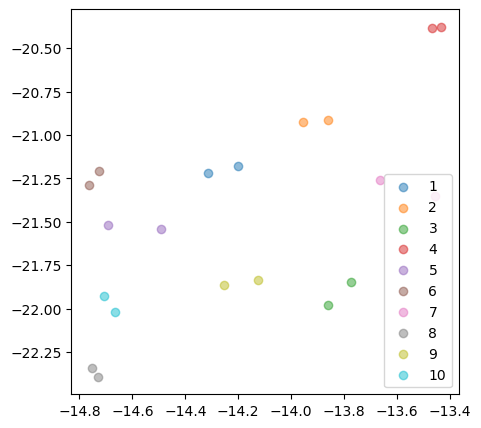

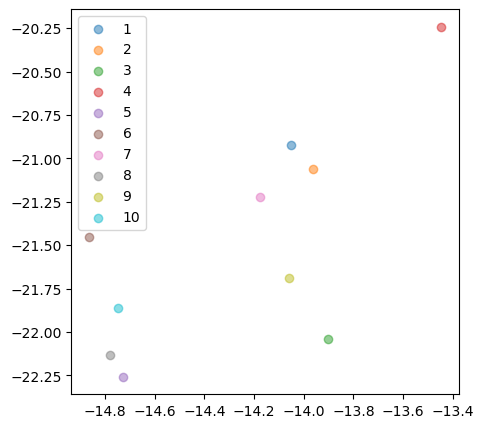

In [71]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model, device)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model, device)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [ ]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 64
# kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
kwargs = {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [ ]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.998970
Train: [12800/60000 (21%)]	Loss: 0.297927
Train: [25600/60000 (43%)]	Loss: 0.126771
Train: [38400/60000 (64%)]	Loss: 0.087683
Train: [51200/60000 (85%)]	Loss: 0.069522
Epoch: 1/20. Train set: Average loss: 0.1353
Epoch: 1/20. Validation set: Average loss: 0.0730
Train: [0/60000 (0%)]	Loss: 0.038108
Train: [12800/60000 (21%)]	Loss: 0.056230
Train: [25600/60000 (43%)]	Loss: 0.051297
Train: [38400/60000 (64%)]	Loss: 0.043096
Train: [51200/60000 (85%)]	Loss: 0.042051
Epoch: 2/20. Train set: Average loss: 0.0472
Epoch: 2/20. Validation set: Average loss: 0.0351
Train: [0/60000 (0%)]	Loss: 0.043380
Train: [12800/60000 (21%)]	Loss: 0.035425
Train: [25600/60000 (43%)]	Loss: 0.034257
Train: [38400/60000 (64%)]	Loss: 0.031027
Train: [51200/60000 (85%)]	Loss: 0.026126
Epoch: 3/20. Train set: Average loss: 0.0309
Epoch: 3/20. Validation set: Average loss: 0.0309
Train: [0/60000 (0%)]	Loss: 0.026385
Train: [12800/60000 (21%)]	Loss: 0.027615
Train: [25600/60000 (

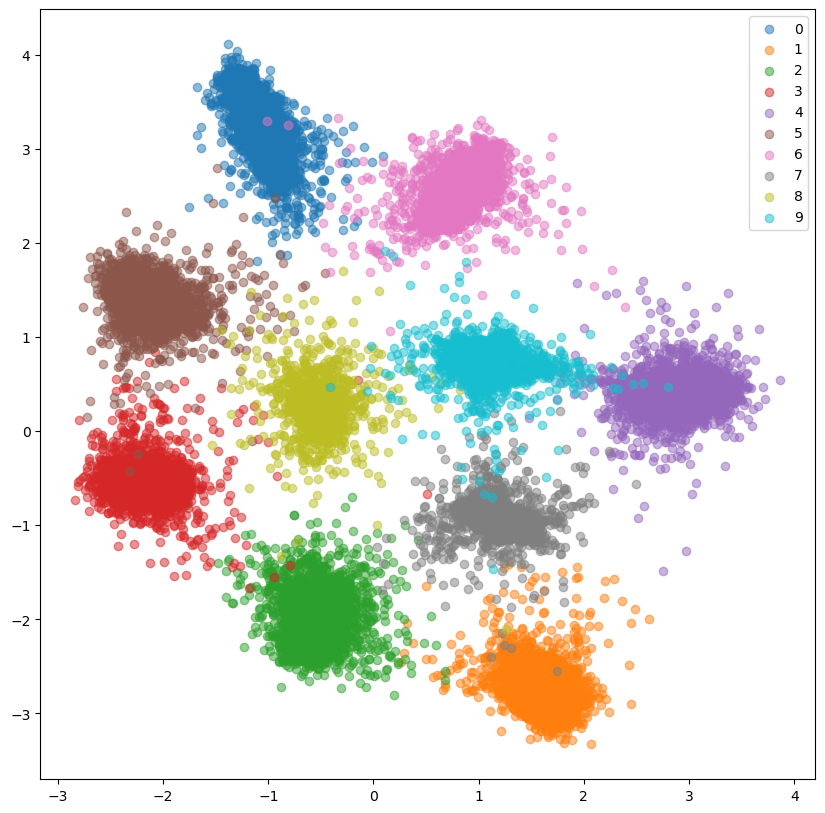

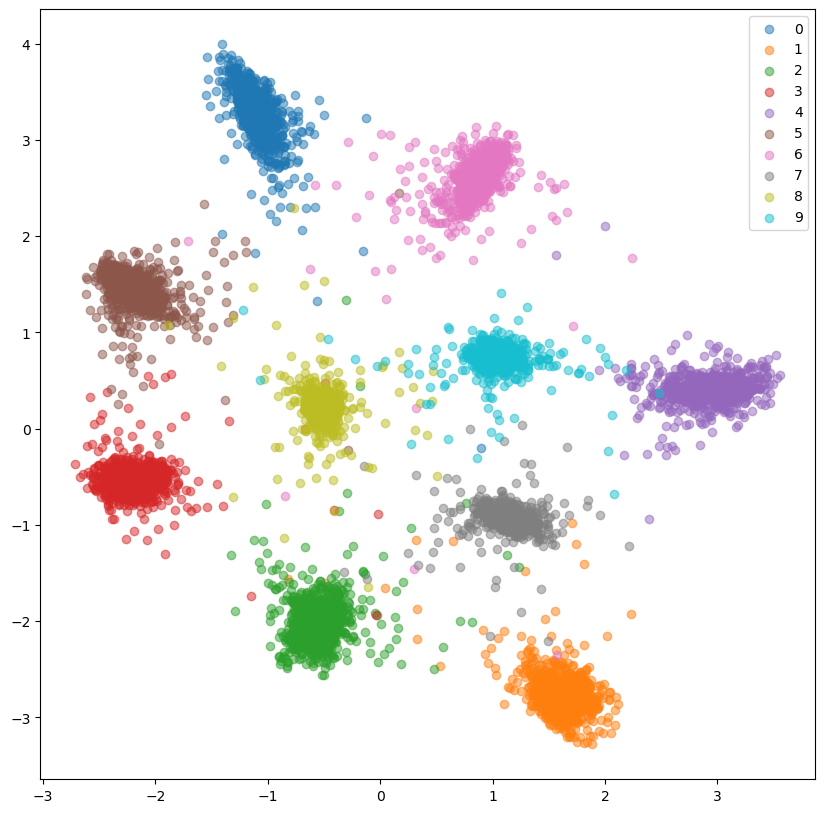

In [ ]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.491198
Train: [12500/60000 (21%)]	Loss: 0.298508
Train: [25000/60000 (42%)]	Loss: 0.161406
Train: [37500/60000 (62%)]	Loss: 0.117912
Train: [50000/60000 (83%)]	Loss: 0.078557
Epoch: 1/20. Train set: Average loss: 0.1501
Epoch: 1/20. Validation set: Average loss: 0.0538
Train: [0/60000 (0%)]	Loss: 0.074799
Train: [12500/60000 (21%)]	Loss: 0.048811
Train: [25000/60000 (42%)]	Loss: 0.047759
Train: [37500/60000 (62%)]	Loss: 0.039152
Train: [50000/60000 (83%)]	Loss: 0.040501
Epoch: 2/20. Train set: Average loss: 0.0426
Epoch: 2/20. Validation set: Average loss: 0.0325
Train: [0/60000 (0%)]	Loss: 0.039617
Train: [12500/60000 (21%)]	Loss: 0.023861
Train: [25000/60000 (42%)]	Loss: 0.029169
Train: [37500/60000 (62%)]	Loss: 0.028539
Train: [50000/60000 (83%)]	Loss: 0.026303
Epoch: 3/20. Train set: Average loss: 0.0266
Epoch: 3/20. Validation set: Average loss: 0.0270
Train: [0/60000 (0%)]	Loss: 0.018346
Train: [12500/60000 (21%)]	Loss: 0.020812
Train: [25000/60000 (

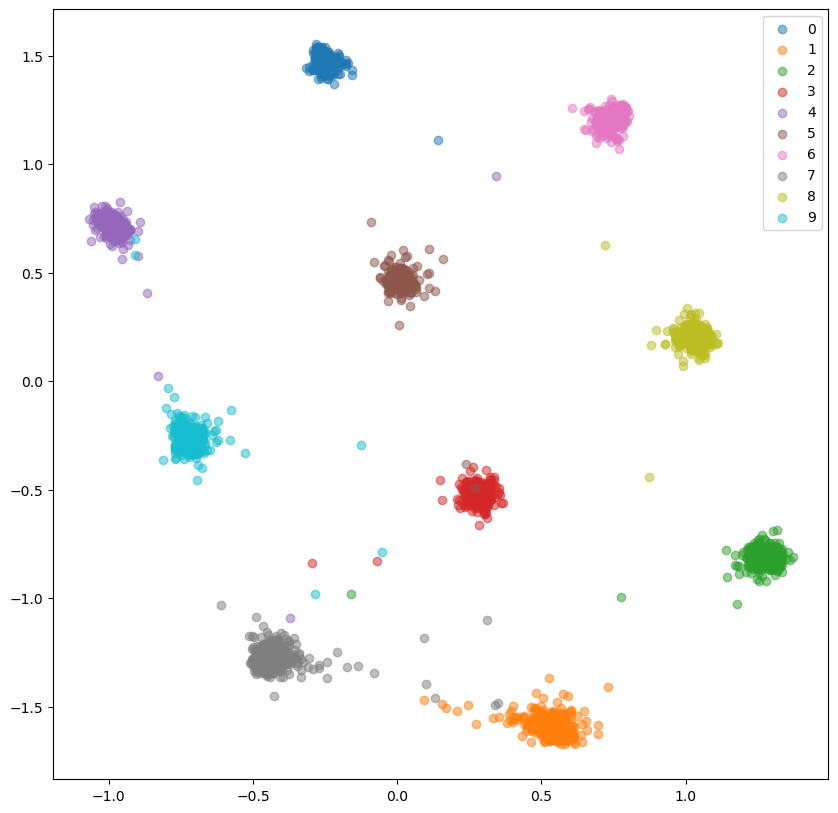

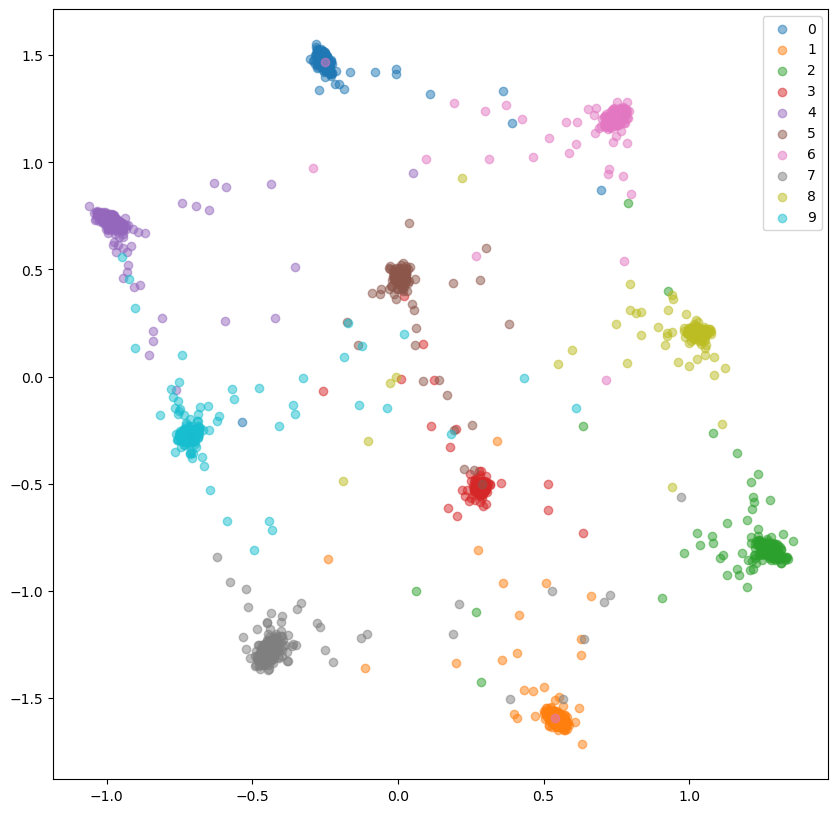

In [ ]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net

# Set device to CUDA if a CUDA device is available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, device, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999366	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.984601	Average nonzero triplets: 2721.9803921568628
Train: [25000/60000 (42%)]	Loss: 0.972755	Average nonzero triplets: 2420.3762376237623
Train: [37500/60000 (62%)]	Loss: 0.966807	Average nonzero triplets: 2157.437086092715
Train: [50000/60000 (83%)]	Loss: 0.964270	Average nonzero triplets: 1953.452736318408
Epoch: 1/20. Train set: Average loss: 0.9785	Average nonzero triplets: 1844.1464435146443
Epoch: 1/20. Validation set: Average loss: 1.0918	Average nonzero triplets: 984.8461538461538
Train: [0/60000 (0%)]	Loss: 1.241617	Average nonzero triplets: 1037.0
Train: [12500/60000 (21%)]	Loss: 0.973798	Average nonzero triplets: 949.9803921568628
Train: [25000/60000 (42%)]	Loss: 1.061108	Average nonzero triplets: 962.1287128712871
Train: [37500/60000 (62%)]	Loss: 0.972767	Average nonzero triplets: 934.5960264900663
Train: [50000/60000 (83%)]	Loss: 1.067278	Average nonzero triplets: 922.

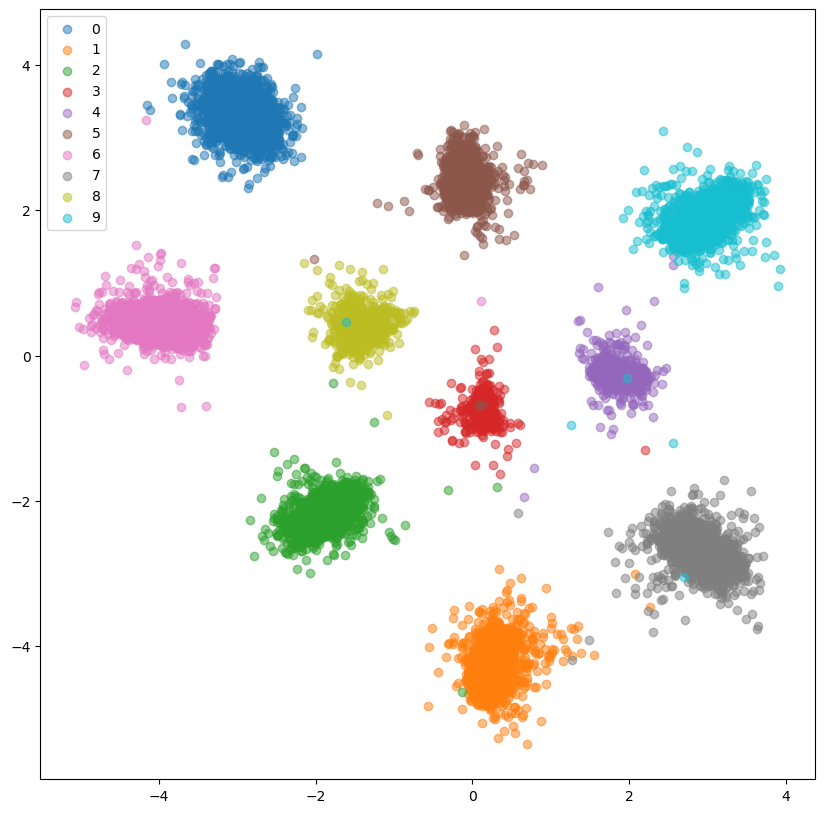

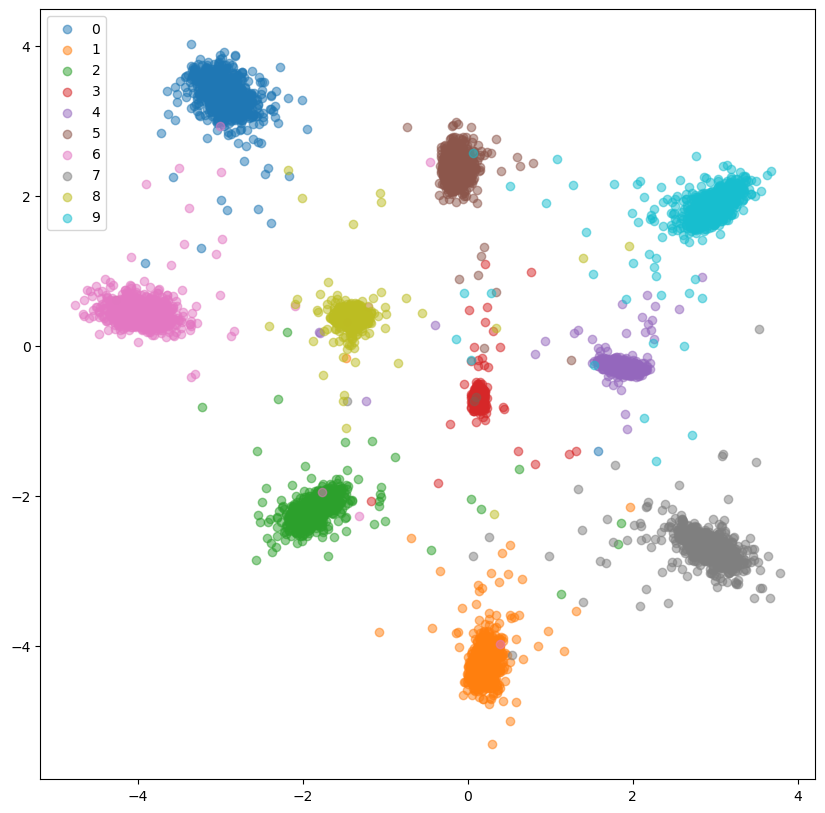

In [19]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

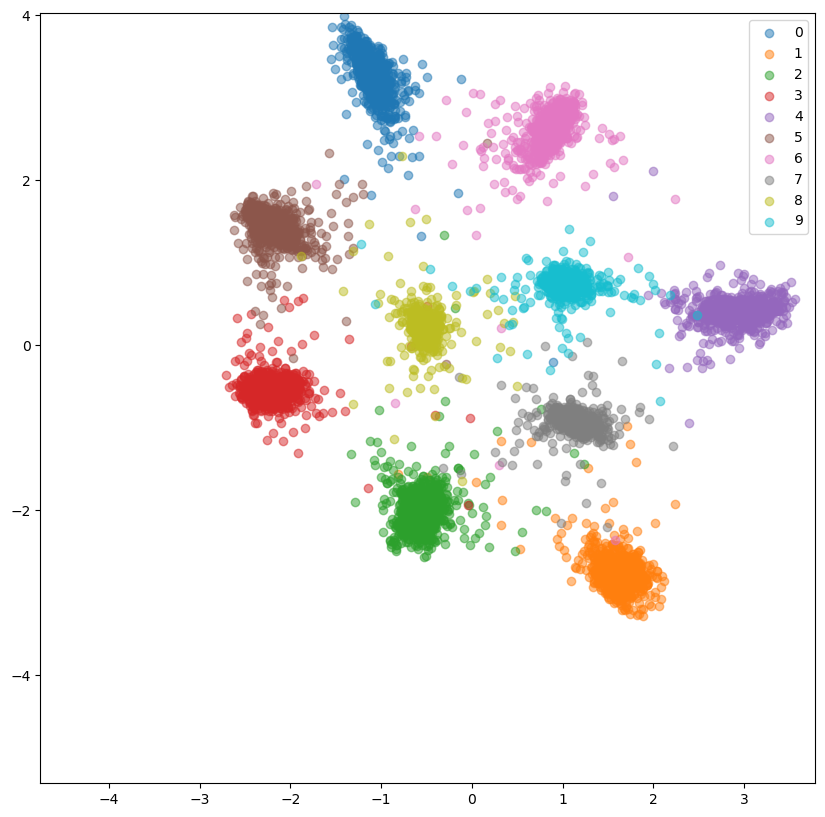

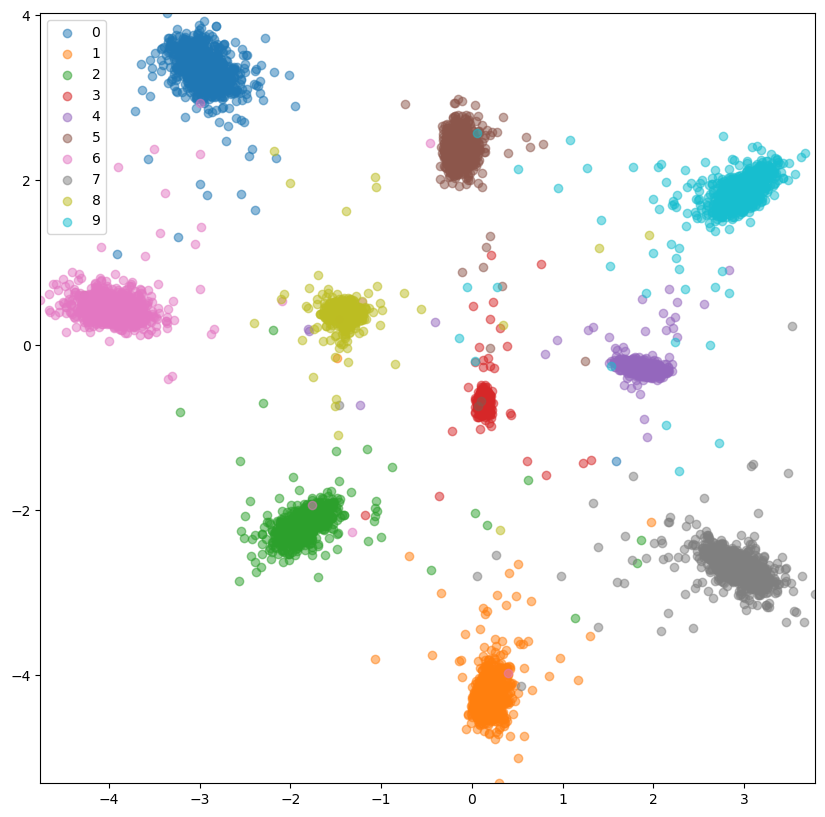

In [20]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

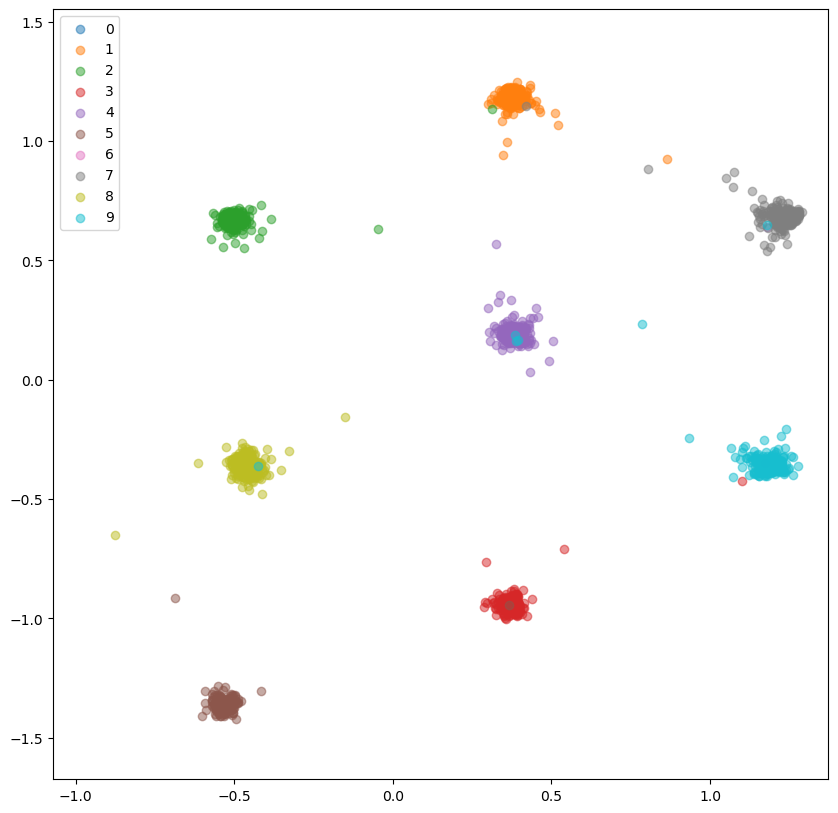

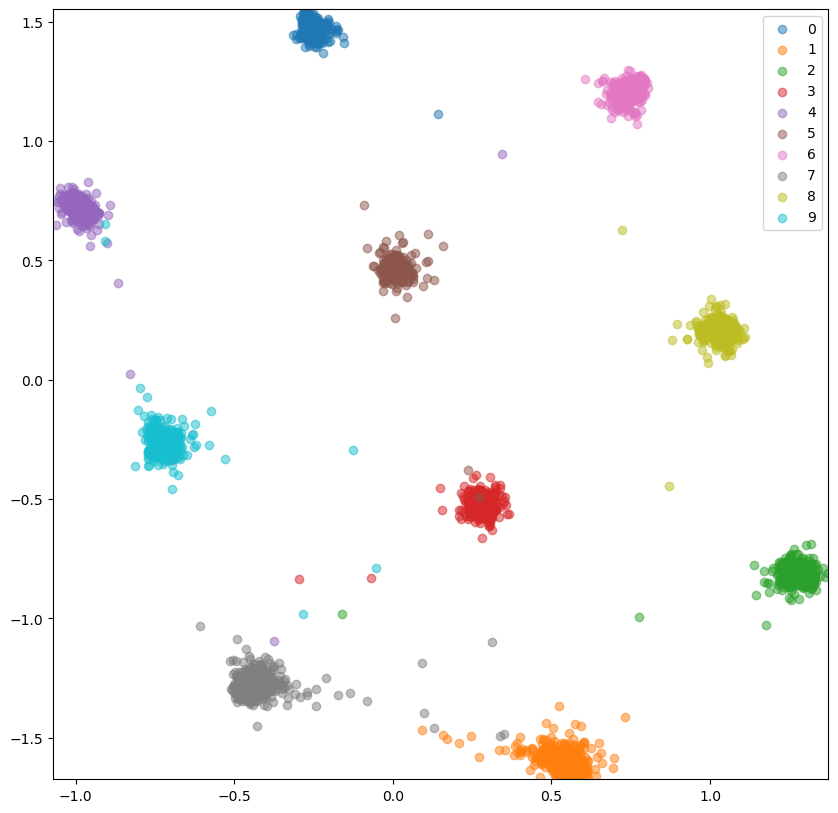

In [21]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)